When a hit is detected by seticore in the COSMIC pipeline, a small portion of the dynamic spectra around the hit is saved to a stamp file. We only save a small portion because the dynamic spectra contains a lot of data. Even so, if there are lots of these stamp files, space fills up quickly. How can we reduce the number of stamp files which are saved?

Well one way would be to reduce the number of false positives detected by the pipeline. These correspond to events which are detected as hits but don't really fit the definition of a potential astrophysical technosignature.

One big source of false positives at the moment is SARFI (single-antenna RFI). Since all the antennas are pointed at the same point in the sky, we'd expect that if a signal was coming from space, we'd see it in all the antennas. However, sometimes a local source of interference near an antenna (or in the signal processing pipeline) creates a signal which appears in only one antenna. This gets picked up as a technosignature hit, but isn't something we really care to look for.

If we can determine when a detected hit is SARFI or not, we can prevent COSMIC from saving those stamp files, freeing up a lot of space and allowing COSMIC to search farther and faster. It also means that there would be less RFI to sift through to find any genuine technosignatures, improving sensitivity.

In this notebook, I will try to define a function which, when given a stamp file, determines if it contains SARFI or not for use in the pipeline. I will test the functionality here as well. However, because the pipeline is distributed and parallelized, the function written here in Python will need to be adapted for use in the pipeline code itself. Hopefully this will adequately show a proof of concept and provide a clear pathway for implementation in the pipeline itself.

In [74]:
# Import packages we'll need (on stamp_viewer env on cosmic-gpu-1)
import numpy as np
from seticore import viewer

# For plotting and visualization
import matplotlib.pyplot as plt

In [75]:
# Example stamp path: (on cosmic-gpu-1)
DATA_PATH = "/mnt/cosmic-storage-2/data1/vla_target/23A-362.sb43789194.eb44583327.60212.544836180554/23A-362.sb43789194.eb44583327.60212.544836180554.9.1/"
BFR_PATH = DATA_PATH + "23A-362.sb43789194.eb44583327.60212.544836180554.9.1.AC.C704.0000.bfr5"
STAMPS_PATH = DATA_PATH + "23A-362.sb43789194.eb44583327.60212.544836180554.9.1.AC.C704.0000.raw.seticore.0000.stamps"

In [76]:
# Read in stamps
stamps_gen = viewer.read_stamps(STAMPS_PATH, find_recipe=True)
stamps = []
for stamp in stamps_gen:
    stamps.append(stamp)
    assert(stamp != None)
    assert(stamp.recipe != None)

print("Found:", len(stamps), "stamps")

Found: 49 stamps


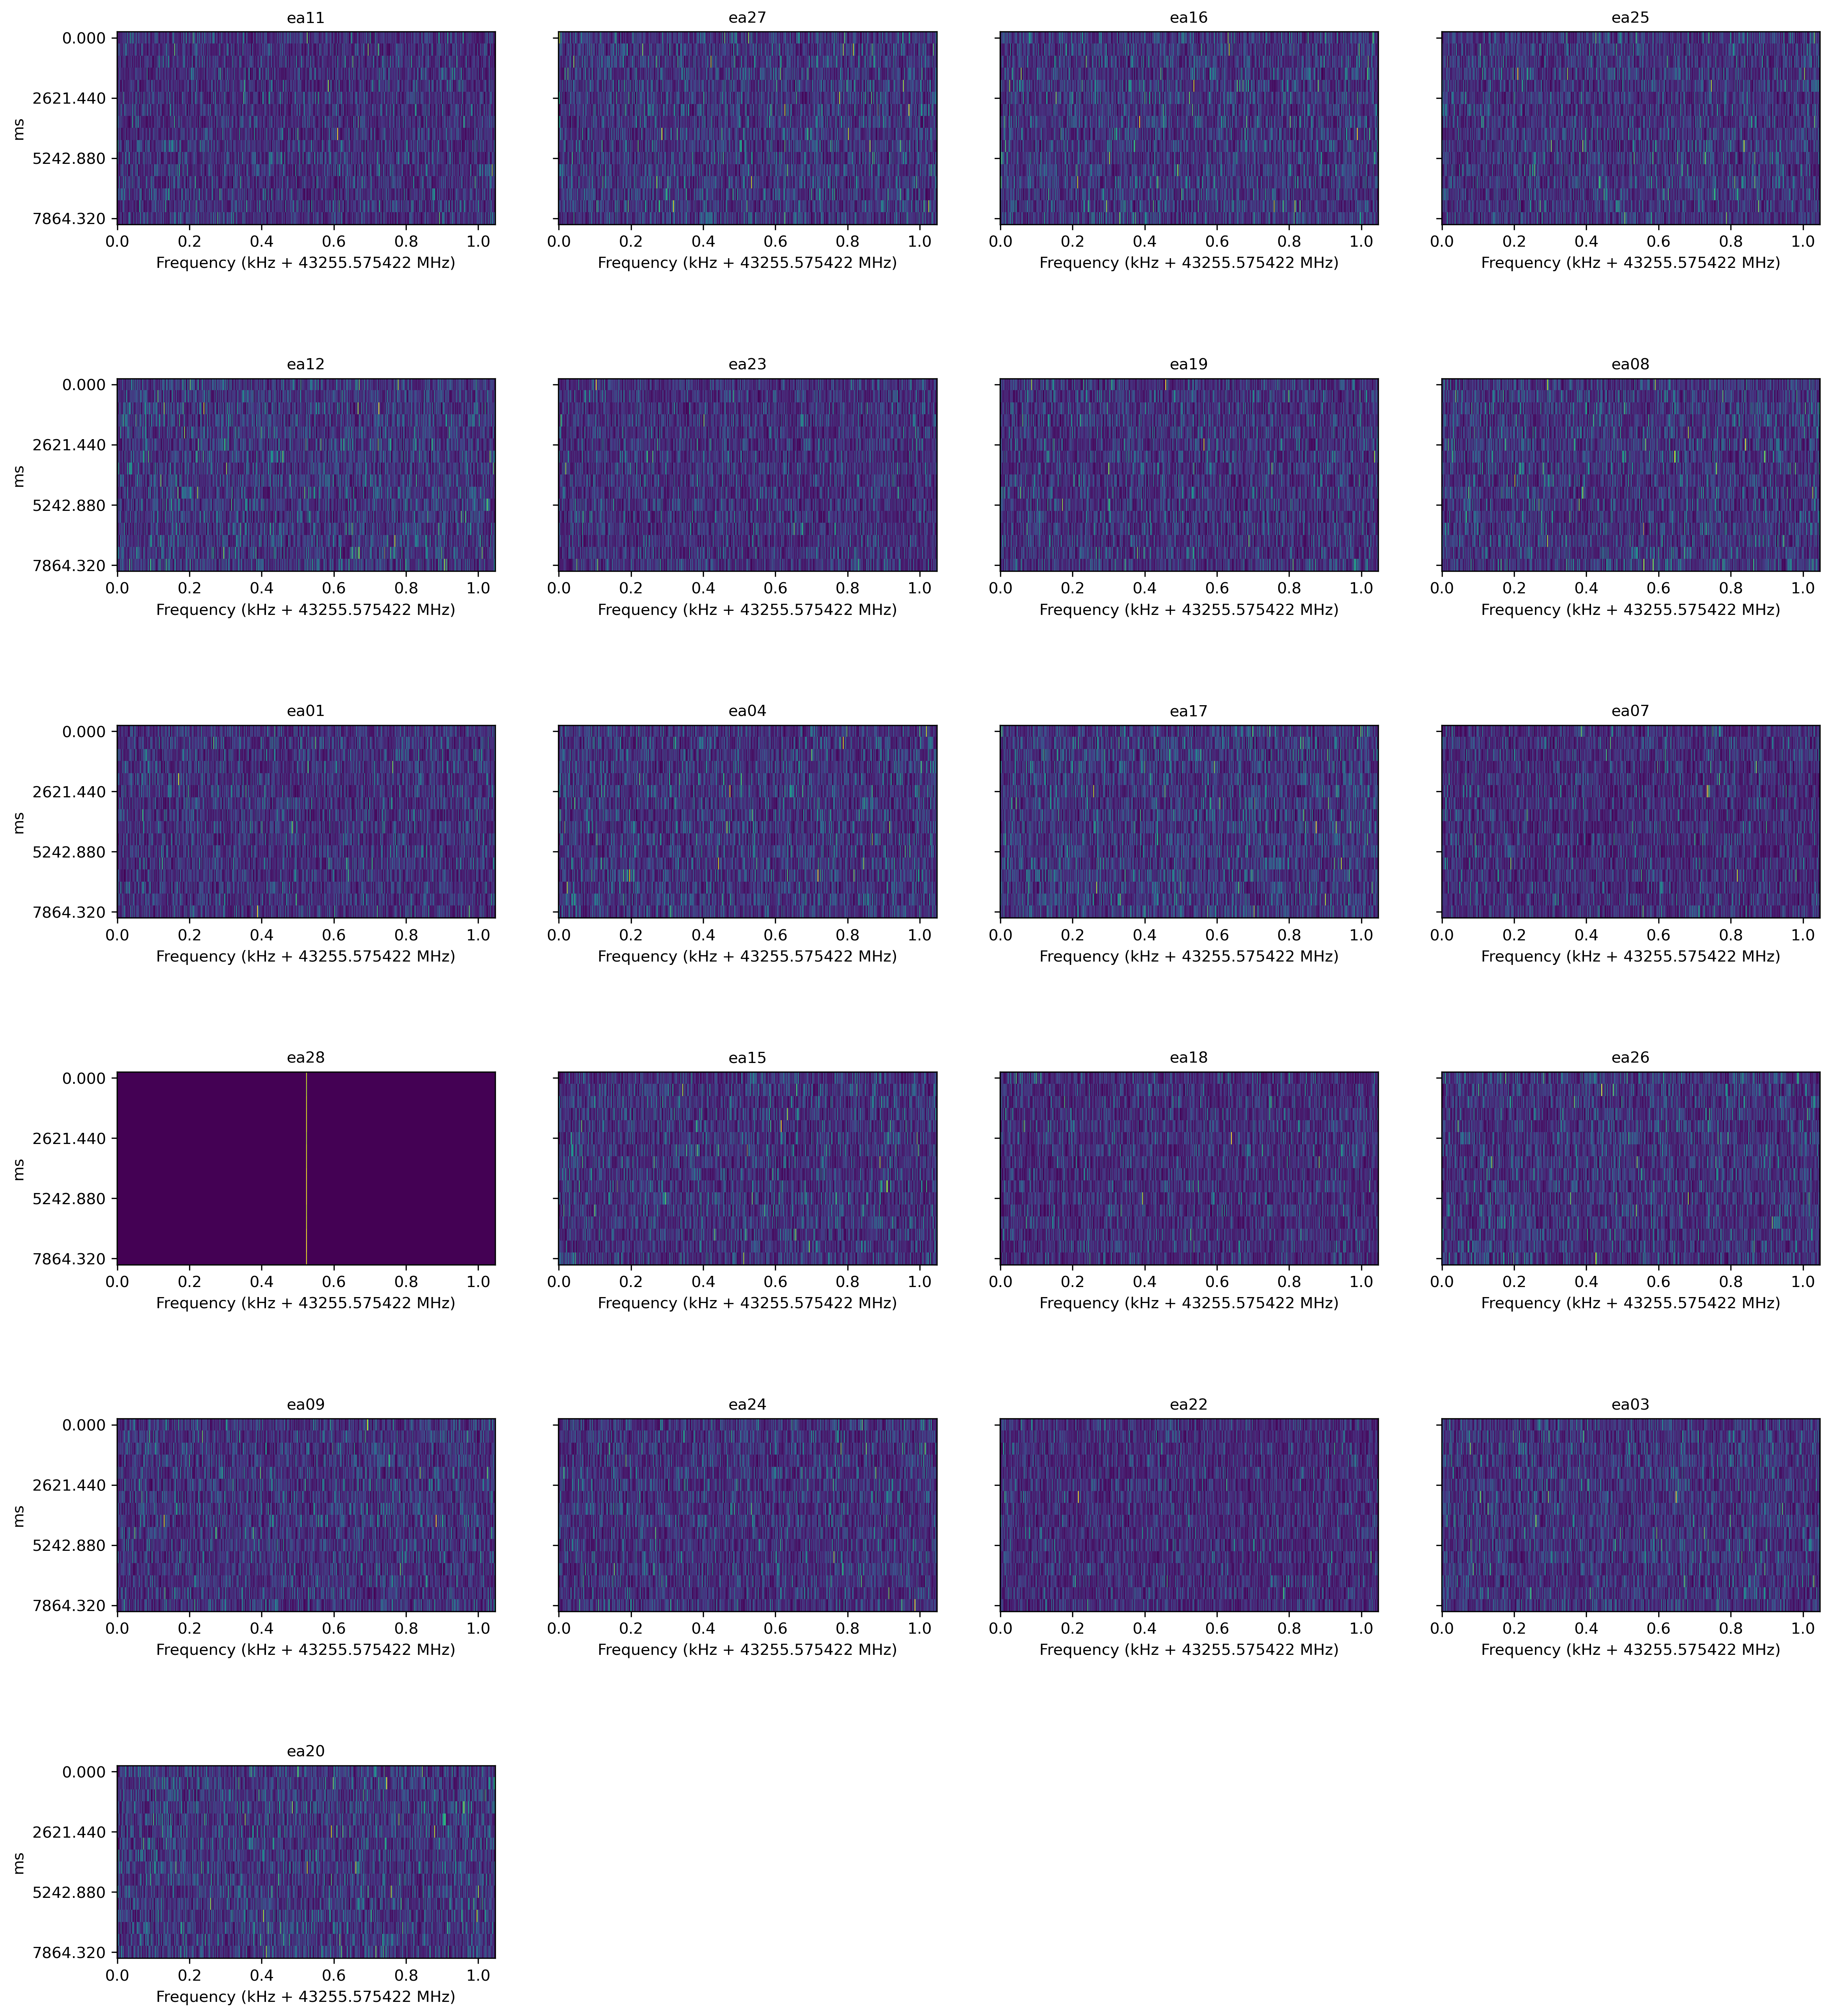

In [77]:
# Look at the first stamp, should be SARFI
stamp = stamps[0]
stamp.show_antennas()

In [78]:
# Define a function which finds out how much of the signal is present in each
# antenna. Returns an array of length n_antennas containing floats [0, 1]
# Note: I think this calculates the portion of the INCOHERENT sum of the antennas
def signal_distribution(stamp):
    # Get the intensities in the frequency bins of each antenna by summing 
    # over squares of polarization and complex magnitude
    # Also rearrange so indices are (antenna, time bin, frequency bin)
    intensities = np.square(stamp.real_array()).sum(axis=(2, 4)).transpose(2, 0, 1)
    
    # Figure out how much signal comes from each antenna
    signals = [(intensity * stamp.signal_mask()).sum() for intensity in intensities]
    
    # Return fraction of total signal contributed by each antenna
    total = sum(signals)
    return [signal / total for signal in signals]

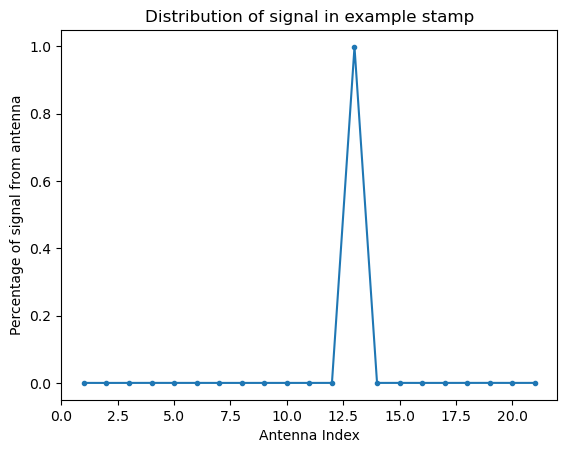

In [79]:
plt.plot(range(1, 22, 1), signal_distribution(stamp), marker='.')
plt.xlabel("Antenna Index")
plt.ylabel("Percentage of signal from antenna")
plt.title("Distribution of signal in example stamp")
plt.show()

In [80]:
# So the maximum value in this array tells us how much the signal is concentrated
# in a single antenna. I'll say if one antenna has >50% of the signal (so all 
# other antennas combined contributed <50%) then this was a SARFI event
print(max(signal_distribution(stamp)), "> 50%, so this was SARFI")

0.9983828315141287 > 50%, so this was SARFI


In [81]:
# Returns true if the stamp is classified as SARFI
# according to the definition:
# A single antenna contributed >50% of the incoherent signal which caused the 
# hit to be detected as a technosignature in the first place
def is_SARFI(stamp):
        return max(signal_distribution(stamp)) > 0.5

In [82]:
# Look at all the stamps in this example file
was_SARFI = []
was_not_SARFI = []
for i, stamp in enumerate(stamps):
        # print(f"Stamp: {i} {'was' if is_SARFI(stamp) else 'was not'} SARFI")
        if is_SARFI(stamp):
            was_SARFI.append(i)
        else:
            was_not_SARFI.append(i)

print(f"Stamps {was_SARFI} were SARFI")
print(f"Stamps: {was_not_SARFI} weren't SARFI")

Stamps [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 40, 41, 42, 43, 44, 45, 46, 47] were SARFI
Stamps: [28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 48] weren't SARFI


In [83]:
# I've looked at these stamps by eye, and I know that these are the actual ones
# which I'd say have SARFI in them and the ones which don't
stamps_with_SARFI = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 40, 41, 42, 43, 44, 45, 46, 47]

In [84]:
# Let's see how this method does

# Check for anything we missed (should have gotten)
false_negatives = [] # stamps which were SARFI but were missed
for index in stamps_with_SARFI:
        if index not in was_SARFI:
                false_negatives.append(false_negatives)

# Check for anything we accidentally got (shouldn't have gotten)
false_positives = [] # stamps which weren't SARFI but we said were
for index in was_SARFI:
        if index not in stamps_with_SARFI:
                false_positives.append(index)

# Report results
if len(false_negatives) == 0 and len(false_positives) == 0:
        print("Algorithm worked!")
else:
        print("Missed some")
        print("False Positives:", false_positives)
        print("False Negatives:", false_negatives)

Algorithm worked!
